# Reproducibility of the dataset underpinning the Copernicus Interactive Climate Atlas: Case study

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Production date: DD-MM-YYYY

Dataset version: 2.0.

Produced by: C3S2_521 contract.

## 🌍 Use case: Retrieving climate indicators from the Copernicus Interactive Climate Atlas

## ❓ Quality assessment question
* **Are the climate indicators in the dataset underpinning Copernicus Interactive Climate Atlas consistent with their source datasets?**

The [_Copernicus Interactive Climate Atlas_](https://atlas.climate.copernicus.eu/atlas), or _Atlas_ for short, is a C3S web application providing an easy-to-access tool for exploring climate projections, reanalyses, and observational data [[Guti24](https://doi.org/10.21957/ah52ufc369)].
The application allows the user to interact with 12 datasets:

| Type               | Dataset       |
|--------------------|---------------|
| Climate Projection | CMIP6         |
| Climate Projection | CMIP5         |
| Climate Projection | CORDEX-CORE   |
| Climate Projection | CORDEX-EUR-11 |
| Reanalysis         | ERA5          |
| Reanalysis         | ERA5-Land     |
| Reanalysis         | ORAS5         |
| Reanalysis         | CERRA         |
| Observations       | E-OBS         |
| Observations       | BERKEARTH     |
| Observations       | CPC           |
| Observations       | SST-CCI       |

These datasets are provided through an intermediary dataset, the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) or _Atlas dataset_ for short [[AtlasData](https://doi.org/10.24381/cds.h35hb680)].
Compared to their origins, the versions of the climate datasets within the Atlas dataset have been processed following the workflow in Figure {numref}`{number} <workflow-fig>`.

```{figure} attachment:atlas_dataset_workflow.png
---
height: 360px
name: workflow-fig
---
Schematic representation of the workflow for the production of the Atlas dataset from its origin datasets, from the [User-tools for the C3S Atlas](https://ecmwf-projects.github.io/c3s-atlas/chapter01.html).
```

Because a wide range of users interact with climate data through the Atlas application, it is crucial that the underpinning dataset represent its origins correctly.
In other words, the Atlas dataset must be reproducible from its origins.
In this notebook, we assess this reproducibility by comparing climate indicators retrieved from the Atlas dataset with their equivalents calculated from the origin dataset, mirroring the workflow from Figure {numref}`{number} <workflow-fig>`.
While a full reproduction of the Atlas dataset is outside the scope of quality assessment (and would require high-performance computing infrastructure), a case study with a narrower scope probes the reproducibility of the datasets and can be a jumping-off point for further analysis by the reader.

This assessment is part of a series:
| Notebook | Contents |
|---|---|
| [](./derived_multi-origin-c3s-atlas_consistency_q01) | Comparison between Atlas dataset and one origin dataset (CMIP6) for one indicator (`tx35`), including detailed setup. |
| [](./derived_multi-origin-c3s-atlas_consistency_q02) | Comparison between Atlas dataset and one origin dataset (CMIP6) for multiple indicators. |
| [](./derived_multi-origin-c3s-atlas_consistency_q03) | Comparison between Atlas dataset and multiple origin datasets for one indicator. |
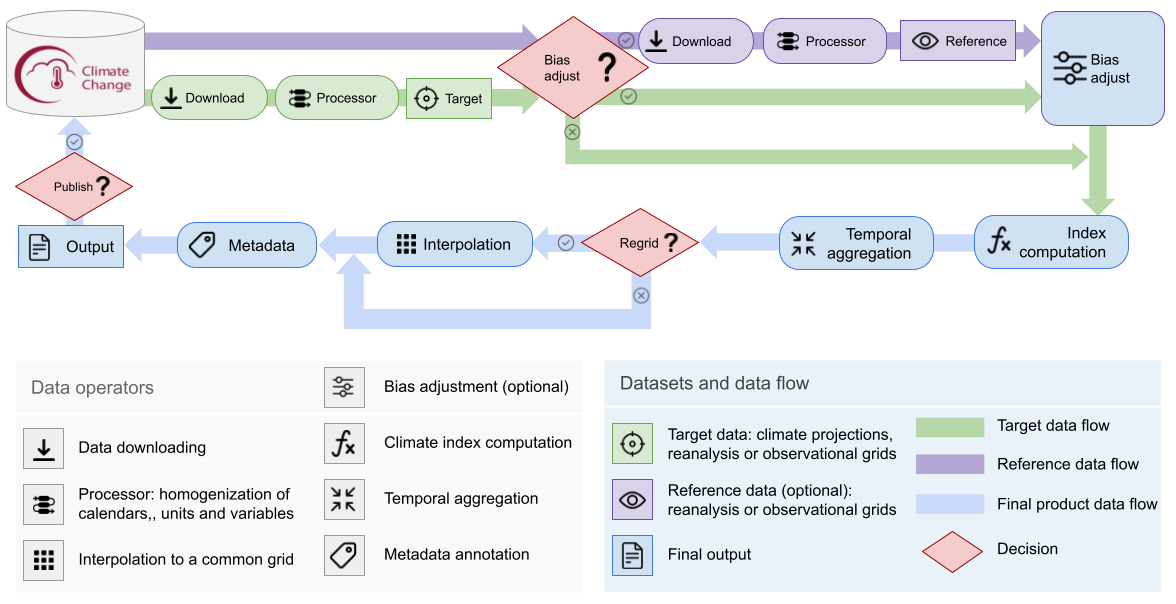

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1: will be a statement on the findings regarding the consistency 
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology
This quality assessment tests the consistency between climate indicators retrieved from the [_Gridded dataset underpinning the Copernicus Interactive Climate Atlas_](https://doi.org/10.24381/cds.h35hb680) [[AtlasData](https://doi.org/10.24381/cds.h35hb680)] and their equivalents calculated from the origin dataset.

This notebook starts the quality assessment with a simple case study: one climate indicator derived from one origin dataset.
We start with the _Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C_ indicator (`tx35`) derived from CMIP6, following [one of the reproducibility notebooks](https://ecmwf-projects.github.io/c3s-atlas/notebooks/tx35.html) written by the data provider.

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-codesetup)**
 * Install User-tools for the C3S Atlas.
 * Import all required libraries.
<!---
 * Definition of helper functions.
--->
**[](section-origin)**
 * Download data from the origin dataset(s).
 * Homogenise data.
 * Calculate indicator(s).
 * Interpolate to a common and regular grid.

**[](section-atlas)**
 * Download data from the Atlas dataset.

**[](section-results)**
 * Compare between the origin and Atlas datasets:
    * Side-by-side maps (regional)
    * Side-by-side maps (global)
    * Difference metrics (global)

## 📈 Analysis and results

(section-codesetup)=
### 1. Code setup
```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for 
downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) 
and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data.
Because earthkit is in active development, some functionality may change after this notebook is published.
If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Install the User-tools for the C3S Atlas
This notebook uses the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas), which can be installed from GitHub using `pip`.
For convenience, we can do this within the notebook itself.
Further details and alternative options for installing this library are available in its [documentation](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements).

In [ ]:
!pip install git+https://github.com/ecmwf-projects/c3s-atlas.git

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [ ]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd

# General data handling
import numpy as np
import xarray as xr
from functools import partial

# Data pre-processing
from c3s_atlas.fixers import apply_fixers
# import c3s_atlas.interpolation as xesmfCICA

# Climate indicators
import xclim

# Visualisation
import earthkit.plots as ekp
import matplotlib.pyplot as plt
plt.rcParams["grid.linestyle"] = "--"

# Comparison metrics
# NB we can rewrite these, remove a dependency
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### Define indicators

In [ ]:
# Functions to calculate indicators
def cal_tx35(ds: xr.Dataset) -> xr.Dataset:
    """ Monthly count of days with maximum near-surface (2-metre) air temperature above 35 °C """
    ds_tx35 = xclim.indices.tx_days_above(ds["tasmax"], thresh="35.0 degC", freq="MS", op=">").to_dataset(name="tx35")
    return ds_tx35

In [ ]:
# Styles for indicators
styles = {
    "tx35": ekp.styles.Style(cmap=plt.cm.YlOrBr, levels=np.arange(0, 32, 1), normalize=False),
}

#### Helper functions

In [ ]:
# Type hints
from typing import Iterable, Optional
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

In [ ]:
# Atlas dataset: Individual model selection
def select_model_from_atlas_dataset(data: xr.Dataset, model: str) -> xr.Dataset:
    """ Select only data for the given model. """
    # Ensure the model ID is provided in the right format
    model_id = model.replace("_", "-")

    # Find the corresponding model ID in the list of models
    # This cannot use .sel because the coordinate is not indexed
    select_member = [str(mem) for mem in data.member_id.values if model_id in mem.lower()][0]

    # Find the corresponding data and return those
    member_ind = np.where(data.member_id == select_member)[0]
    data_member = data.sel(member=member_ind).squeeze("member")

    return data_member

# Select (multiple) years in a dataset
def select_years_in_dataset(data: xr.Dataset, years: list[int]) -> xr.Dataset:
    """ Select only data for the given year(s). """
    return data.sel(time=data.time.dt.year.isin(years))

# Select one month in multiple datasets
def select_month_in_multiple_datasets(*data: xr.Dataset, month: int=8) -> list[xr.Dataset]:
    """ Select only data for the given month, in any year. """
    data_month = [d.groupby("time.month")[month] for d in data]
    return data_month

In [ ]:
# Visualisation: Helper functions, general
def _add_textbox_to_subplots(text: str, *axs: Iterable[plt.Axes | ekp.Subplot], right=False) -> None:
    """ Add a text box to each of the specified subplots. """
    # Get the plt.Axes for each ekp.Subplot
    axs = [subplot.ax if isinstance(subplot, ekp.Subplot) else subplot for subplot in axs]

    # Set up location
    x = 0.95 if right else 0.05
    horizontalalignment = "right" if right else "left"

    # Add the text
    for ax in axs:
        ax.text(x, 0.95, text, transform=ax.transAxes,
        horizontalalignment=horizontalalignment, verticalalignment="top",
        bbox={"facecolor": "white", "edgecolor": "black", "boxstyle": "round",
              "alpha": 1})

In [ ]:
# Visualisation: Helper functions for geospatial plots
def _spatial_plot_append_subplots(fig: ekp.Figure, *data: xr.Dataset, domain: Optional[AnyDomain]=None, **kwargs) -> list[ekp.Subplot]:
    """ Plot any number of datasets into new subplots in an existing earthkit figure. """
    # Create subplots
    subplots = [fig.add_map(domain=domain) for d in data]

    # Plot
    for subplot, d in zip(subplots, data):
        subplot.grid_cells(d, **kwargs)

    return subplots

In [ ]:
# Visualisation: Plot indicators geospatially
def geospatial_comparison(data1: xr.Dataset, data2: xr.Dataset, indicator: str, month: int, *,
                          label1: str="Atlas dataset", label2: str="Reproduced from origin",
                          domain: Optional[str | Domain]=None) -> ekp.Figure:
    """
    Plot one indicator in two datasets.
    If multiple years are present, loops over those using groupby.
    A specific month has to be specified.
        TO DO: glue
    """
    # Select data from one month
    data_by_month = select_month_in_multiple_datasets(data1, data2)
    
    # Group data by year
    data1_years, data2_years = [d.groupby("time.year") for d in data_by_month]
    nr_years = len(data1_years)

    # Create figure
    fig = ekp.Figure(rows=nr_years, columns=2, size=(8, 3*nr_years), hspace=0.1, wspace=0.1)

    # Plot indicators
    for (year, d1), (_, d2) in zip(data1_years, data2_years):
        # Remove redundant time coordinate
        d1, d2 = [d.drop_vars("time") for d in (d1, d2)]
        
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, d1, d2, domain=domain, z=indicator, style=styles[indicator])
    
        # Show year
        _add_textbox_to_subplots(year, *subplots_data)

        # Colour bar on the right
        subplots_data[-1].legend(label=indicator, location="right")

    # Titles on top
    titles = [label1, label2]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
    fig.title("Geospatial comparison: {domain}")
    
    # Uncomment if running this notebook yourself:
    # Show result
    plt.show()

    # TO DO: glue
    return fig

In [ ]:
# Visualisation: Plot indicator + difference geospatially
def spatial_plot_with_difference(data1: xr.Dataset, data2: xr.Dataset, indicator: str, month: int, *,
                                 label1: str="Atlas dataset", label2: str="Reproduced from origin",
                                 domain: Optional[str | Domain]=None) -> ekp.Figure:
    """
    Plot one indicator in two datasets, including the difference between them.
    If multiple years are present, loops over those using groupby.
    A specific month has to be specified.
        TO DO: glue
    """
    # Select data from one month
    data_by_month = select_month_in_multiple_datasets(data1, data2)
    
    # Group data by year
    data1_years, data2_years = [d.groupby("time.year") for d in data_by_month]
    nr_years = len(data1_years)

    # Create figure
    fig = ekp.Figure(rows=nr_years, columns=3, size=(8, 3*nr_years))

    # Plot indicators
    for (year, d1), (_, d2) in zip(data1_years, data2_years):
        # Remove redundant time coordinate
        d1, d2 = [d.drop_vars("time") for d in (d1, d2)]
        
        # Plot individual datasets
        subplots_data = _spatial_plot_append_subplots(fig, d1, d2, domain=domain, z=indicator, style=styles[indicator])
    
        # Plot difference
        # difference = xr.ufuncs.subtract(d1, d2)
        subplot_diff = fig.add_map(domain=domain)
        # subplot_diff.grid_cells(difference, z=indicator, style=styles["difference"])
    
        # Show year
        _add_textbox_to_subplots(year, *subplots_data, subplot_diff)

    # Colour bar at the bottom
    for subplot in subplots_data:
        subplot.legend(label=indicator, location="bottom")
    subplot_diff.legend(label="Difference", location="bottom")

    # Titles on top
    titles = [label1, label2, "Difference"]
    for title, subplot in zip(titles, fig.subplots):
        subplot.ax.set_title(title)

    # Decorate figure
    fig.land()
    fig.coastlines()
    fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
    fig.title("Geospatial comparison: {domain}")
    
    # Uncomment if running this notebook yourself:
    # Show result
    plt.show()

    # TO DO: glue
    return fig

In [ ]:
# Visualisation: Plot data + difference in histograms
def histogram_comparison_by_year(data1: xr.Dataset, data2: xr.Dataset, indicator: str, *,
                                 label1: str="Atlas dataset", label2: str="Reproduced from origin") -> plt.Figure:
    """
    Plot one indicator in two datasets, for multiple years.
    Flattens all data in the datasets, including spatial and temporal dimensions.
        TO DO: glue
    """
    # Group data by year
    data1_years, data2_years = [d.groupby("time.year") for d in (data1, data2)]
    nr_years = len(data1_years)
    
    # Create figure
    fig, axs = plt.subplots(nrows=nr_years, ncols=2, sharex=True, sharey=True,
                            figsize=(5, 2*nr_years), layout="constrained", squeeze=False)
    
    # Plot histograms of data
    # Loop over rows / indicators
    for ax_row, (year, d1), (_, d2) in zip(axs, data1_years, data2_years):
        # Loop over columns / data
        for ax, data in zip(ax_row, (d1, d2)):
            # Flatten data
            d = data[indicator].values.ravel()
    
            # Create histogram
            ax.hist(d, bins=styles["tx35"].levels(), log=True, color="black")
    
            # Labels
            ax.grid(True, axis="both")
            ax.set_xlabel(indicator)
    
        ax_row[0].set_ylabel("Frequency")
        
        # Show year
        _add_textbox_to_subplots(year, *ax_row, right=True)
    
    # Titles on top
    titles = [label1, label2]
    for title, ax in zip(titles, axs[0]):
        ax.set_title(title)
    
    # Decorate figure
    fig.suptitle("Point-by-point comparison")
        
    # Uncomment if running this notebook yourself:
    # Show result
    plt.show()
    
    # TO DO: glue
    return fig

(section-origin)=
### 2. Calculate indicator(s) from the origin dataset(s)

#### Download data
This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.

We first define the parameters that will be shared between the download of the origin dataset (here CMIP6) and the Atlas dataset (in the [next section](section-atlas)), namely the experiment and model member.
We then define the request to download the corresponding data from CMIP6,
in this notebook choosing only the variable necessary to calculate the `tx35` indicator, namely `daily_maximum_near_surface_air_temperature`.
Because we will calculate the indicator for multiple years, the `year` parameter of the request is left out for now.

In [ ]:
indicator = "tx35"
experiment = "ssp5_8_5"
model = "cmcc_esm2"

# Define request
CMIP6_ID = "projections-cmip6"
request_CMIP6 = {
    "experiment": experiment,
    "model": model,
    "variable": "daily_maximum_near_surface_air_temperature",
    "temporal_resolution": "daily",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "day": [f"{day:02d}" for day in range(1, 32)],
    "format": "netcdf",
}

In this case study, we will look at
two years, namely 2060 and 2080,
so we create corresponding requests.
This can easily be changed or extended if you want to use different years.
We use separate requests for each year rather than one combined request to limit the size per request.

In [ ]:
years = [2060, 2080]
requests_year = [{"year": str(year)} for year in years]

In [ ]:
requests_CMIP6_combined = [request_CMIP6 | req_year for req_year in requests_year]

# Download data
ds_CMIP6 = ekd.from_source("cds", CMIP6_ID, *requests_CMIP6_combined)

Earthkit downloads the data as a field list.
We convert this into an `xarray` dataset, which can be used in the following steps:

In [ ]:
data_CMIP6 = ds_CMIP6.to_xarray(compat="equals", data_vars="all")
data_CMIP6

#### Homogenise data
One of the steps in the Atlas dataset production chain is homogenisation, i.e. ensuring consistency between data from different origin datasets.
This homogenisation is implemented in the [User-tools for the C3S Atlas](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas), specifically the `c3s_atlas.fixers.apply_fixers` function.
The following changes are applied:

- The names of the spatial coordinates are standardised to `[lon, lat]`.
- Longitude is converted from `[0...360]` to `[-180...180]` format.
- The time coordinate is standardised to the CF standard calendar.
- Variable units are standardised (e.g. °C for temperature).
- Variables are resampled / aggregated to the required temporal resolution.

The homogenisation is applied in the following code cell.
The `apply_fixers` function describes the different homogenisation steps as it applies them.

In [ ]:
# Define the homogenisation function for this case
project_id = "cmip6"
variable = "tasmax"
var_mapping = {
            "dataset_variable": {variable: "data"},
            "aggregation": {"data": "mean"},
}

homogenise = partial(apply_fixers, variable=variable, project_id=project_id, map_variables=var_mapping)

# Apply
# Note the dataset has to be split by year (using groupby) to ensure the aggregation works properly
data_CMIP6_homogenised = data_CMIP6.groupby("time.year").map(homogenise)

The result of the homogenisation step is as follows:

In [ ]:
data_CMIP6_homogenised

#### Calculate indicator(s)
We calculate the climate indicator(s),
in this notebook only `tx35`,
using [xclim](https://xclim.readthedocs.io/en/stable/).
We use the function `cal_tx35`, defined [above](section-codesetup), to calculate the index.
As before, this function needs to be applied year-by-year, which we do using `groupby`.

In [ ]:
indicators_CMIP6 = data_CMIP6_homogenised.groupby("time.year").map(cal_tx35)
indicators_CMIP6

#### Interpolate to a common and regular grid
```{note}
This notebook uses [xESMF](https://github.com/pangeo-data/xESMF) for regridding data.
xESMF is most easily installed using conda as explained in its documentation.
Users who cannot or do not wish to use conda will have to manually compile and install [ESMF](https://earthsystemmodeling.org/docs/release/latest/ESMF_usrdoc/node10.html) on their machines, which is not trivial.
In future, this notebook will use [earthkit-regrid](https://github.com/ecmwf/earthkit-regrid) instead, once it reaches suitable maturity.
```

Interpolation to a common and regular grid using 

In [ ]:

# interpolate data original order
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(-89.5, 90.5, 1),
            'lons' : np.arange(-179.5, 180.5, 1),
            'var_name' : 'tx35'
}

INTER = xesmfCICA.Interpolator(int_attr)

ds_tx35_2060_i = INTER(ds_tx35_2060)
ds_tx35_2080_i = INTER(ds_tx35_2080)


ds_tx35_2060_i

(section-atlas)= 
### 3. Retrieve indicator(s) from the Atlas dataset
Here, we download the same indicator(s) as above directly from the [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://doi.org/10.24381/cds.h35hb680) so they can be compared.

In [ ]:
# Define request
atlas_ID = "multi-origin-c3s-atlas"
request_atlas = {
    "origin": "cmip6",
    "experiment": experiment,
    "period": "2015-2100",
    "variable": "monthly_extreme_hot_days",
    "bias_adjustment": "no_bias_adjustment"
}

# Download data
ds_atlas = ekd.from_source("cds", atlas_ID, request_atlas)
data_atlas = ds_atlas.to_xarray()

The Atlas dataset provides all years and members at the same time, so for convenience we pull out only the relevant entries:

In [ ]:
data_member = select_model_from_atlas_dataset(data_atlas, model)
data_member_years = select_years_in_dataset(data_member, years)

indicators_atlas = data_member_years
indicators_atlas

(section-results)=
### 4. Results
We now compare the indicator(s) retrieved from the Atlas dataset vs those reproduced from the origin dataset.

We first compare the datasets on their native grids.
This means we cannot do a point-by-point comparison
(because the points are not equivalent),
but we can compare the distributions geospatially and overall.
This probes how well the Atlas dataset reproduces the patterns and trends seen in the origin dataset.

The second comparison uses the regridded version of the indicators derived from the origin dataset.
This makes a point-by-point comparison possible.
It probes how well the overall Atlas workflow (Figure {numref}`{number} <workflow-fig>`) can be reproduced.

#### Geospatial distribution on native grids
For the geospatial comparison, we display the values of the indicator for one month,
across one region and globally.
For the example of `tx35`, we use August, since we would expect many warm days in the Northern hemisphere in that month.

In [ ]:
# Setup: Choose a month to display
month = 8

We first plot the results locally,
e.g. in Iberia,
to show spatial patterns in detail.
The area specified below can easily be modified using the [domains provided by earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/examples/guide/05-domains.html).

In [ ]:
# Create domain using earthkit-plots
domain = ekp.geo.domains.union(["Portugal", "Spain"], name="Iberia")

# Create plot with function defined at the start
geospatial_comparison(indicators_atlas, indicators_CMIP6, indicator, month,
                      domain=domain)

We can also plot the results globally to get the full picture:

In [ ]:
geospatial_comparison(indicators_atlas, indicators_CMIP6, indicator, month,
                      domain="global")

#### Overall distribution on native grids
For the overall comparison, we compare the distribution of indicator values across all pixels and months within each year.

In [ ]:
# Histogram
fig_hist = histogram_comparison_by_year(indicators_atlas, indicators_CMIP6, indicator)

#### Geospatial distribution on Atlas grid


In [ ]:
# Create plot with function defined at the start
spatial_plot_with_difference(indicators_atlas, indicators_CMIP6, indicator, month,
                             domain=domain)

In [ ]:
spatial_plot_with_difference(indicators_atlas_month, indicators_cmip6_month, indicator, month,
                             domain="global")

#### Overall distribution on Atlas grid

For a quantitative measure of the differences between the Atlas dataset and the indicators reproduced from the origin dataset,
we perform a point-by-point comparison across the full spatial and temporal dimensions.

In [ ]:
# Histogram
fig_hist = histogram_comparison(indicators_atlas, indicators_CMIP6, indicator)

Next, we calculate difference metrics:

In [ ]:
# Metrics
atlas = ds_tx35_2060_i['tx35']  #DataArray
jn = ds_tx35_C3S_Atlas_2060['tx35']  #DataArray

lat_bounds = (35.5, 44.5)
lon_bounds = (-9.5, 3.5)

atlas_subset = atlas.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
jn_subset = jn.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

# Align time - maybe use xr.align
common_time = np.intersect1d(atlas_subset['time'], jn_subset['time'])
atlas_subset = atlas_subset.sel(time=common_time)
jn_subset = jn_subset.sel(time=common_time)

atlas_flat = atlas_subset.values.flatten()
jn_flat = jn_subset.values.flatten()

# mask out NaNs
mask = ~np.isnan(atlas_flat) & ~np.isnan(jn_flat)
atlas_clean = atlas_flat[mask]
jn_clean = jn_flat[mask]

# calculate metrics
mae = mean_absolute_error(atlas_clean, jn_clean)
rmse = np.sqrt(mean_squared_error(atlas_clean, jn_clean))
correlation = np.corrcoef(atlas_clean, jn_clean)[0, 1]

print(f"MAE Original: {mae:.4f}")
print(f"RMSE Original: {rmse:.4f}")
print(f"Correlation Original: {correlation:.4f}")

#median absolute difference 
# add global plot and metrics

## ℹ️ If you want to know more

### Key resources

List some key resources related to this assessment. E.g. CDS entries, applications, dataset documentation, external pages.
Also list any code libraries used (if applicable).

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)

### References
_To be replaced with numerical references once the text is finished_

[[Guti24](https://doi.org/10.21957/ah52ufc369)] J. M. Gutiérrez et al., ‘The Copernicus Interactive Climate Atlas: a tool to explore regional climate change’, ECMWF Newsletter, vol. 181, pp. 38–45, Oct. 2024, doi: 10.21957/ah52ufc369.

[[AtlasData](https://doi.org/10.24381/cds.h35hb680)] Copernicus Climate Change Service, ‘Gridded dataset underpinning the Copernicus Interactive Climate Atlas’. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), Jun. 17, 2024. doi: 10.24381/cds.h35hb680.